In [ ]:
#«RF Regressor, Feature engineering»

In [66]:
# 1. Загрузка данных
import pandas as pd
train_df = pd.read_csv('D:/Эстер/с рс/Courses/ML Engineer/HWEster28/archive/train.csv')
test_df = pd.read_csv('D:/Эстер/с рс/Courses/ML Engineer/HWEster28/archive/test.csv')
sample_submission_df = pd.read_csv('D:/Эстер/с рс/Courses/ML Engineer/HWEster28/archive/sample_submission.csv')

# Обрезаем данные, чтобы оставить только 5000 строк
train_df = train_df.sample(n=5000, random_state=42)

In [67]:
# 2. EDA (Exploratory Data Analysis)
# a) Доля пропусков
print("Доля пропусков в каждом столбце:")
print(train_df.isnull().mean())
print("\nМаксимальные и минимальные значения:")
print(train_df.describe().loc[['min', 'max']])
train_df_numeric = train_df.select_dtypes(include=['number']) 
print("\nСреднее значение:")
print(train_df_numeric.mean())
print("\nМедиана:")
print(train_df_numeric.median())
print("\nДисперсия:")
print(train_df_numeric.var())
# f) Квантиль 0.1 и 0.9
print("\nКвантиль 0.1 и 0.9:")
print(train_df_numeric.quantile([0.1, 0.9]))
# g) Квартиль 1 и 3
print("\nКвартиль 1 и 3:")
print(train_df_numeric.quantile([0.25, 0.75]))

Доля пропусков в каждом столбце:
id                      0.0000
Age                     0.0158
Gender                  0.0000
Annual Income           0.0372
Marital Status          0.0144
Number of Dependents    0.0934
Education Level         0.0000
Occupation              0.2934
Health Score            0.0612
Location                0.0000
Policy Type             0.0000
Previous Claims         0.3086
Vehicle Age             0.0000
Credit Score            0.1204
Insurance Duration      0.0000
Policy Start Date       0.0000
Customer Feedback       0.0648
Smoking Status          0.0000
Exercise Frequency      0.0000
Property Type           0.0000
Premium Amount          0.0000
dtype: float64

Максимальные и минимальные значения:
            id   Age  Annual Income  Number of Dependents  Health Score  \
min       31.0  18.0           17.0                   0.0      3.049781   
max  1199674.0  64.0       149995.0                   4.0     55.957143   

     Previous Claims  Vehicle Age  Cr

In [68]:
# 3. Обучение модели регрессии RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Кодируем категориальные признаки
train_df_encoded = pd.get_dummies(train_df, drop_first=True)

# Целевая переменная
X = train_df_encoded.drop(columns=['Premium Amount', 'id'])
y = train_df_encoded['Premium Amount']

# Разделяем данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Инициализируем и обучаем модель случайного леса
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [69]:
# 4. Оценка модели 
# Предсказания на тестовой выборке
y_pred = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print("\nОценка модели по критериям качества:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")


Оценка модели по критериям качества:
MAE: 607.0553899999999
MSE: 778334.0221667
RMSE: 882.2324082500597
R^2: -0.05967135509751165


In [70]:
# 5. Применяем генерацию признаков 
import featuretools as ft

# Создаём сущность для использования FeatureTools
es = ft.EntitySet(id='insurance_data')

# Добавляем таблицу в сущность, указываем имя таблицы через dataframe_name
es = es.add_dataframe(dataframe=train_df, dataframe_name='train_data', index='id')

# Генерация признаков
feature_matrix, feature_defs = ft.dfs(entityset=es, target_dataframe_name='train_data')

D:\Yolo8\CVAT2YOLO\WORK\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
D:\Yolo8\CVAT2YOLO\WORK\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
D:\Yolo8\CVAT2YOLO\WORK\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
D:\Yolo8\CVAT2YOLO\WORK\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dat

In [71]:
# 6. Изучаем сгенерированные признаки
print("\nСгенерированные признаки:")
print(feature_matrix.head())

# Убираем NaN и 0
feature_matrix_cleaned = feature_matrix.dropna(axis=1, thresh=0.1*len(feature_matrix))
feature_matrix_cleaned = feature_matrix_cleaned.loc[:, (feature_matrix_cleaned != 0).mean(axis=0) > 0.1]



Сгенерированные признаки:
         Age  Gender  Annual Income Marital Status  Number of Dependents  \
id                                                                         
372605    52  Female           5538        Married                  <NA>   
551204    60  Female          39711        Married                     4   
240320    58  Female           2364        Married                     2   
1047361   39    Male           9094       Divorced                     0   
555362    47    Male          43189       Divorced                  <NA>   

        Education Level Occupation  Health Score  Location    Policy Type  \
id                                                                          
372605         Master's   Employed      8.093145     Rural          Basic   
551204       Bachelor's   Employed           NaN  Suburban  Comprehensive   
240320       Bachelor's        NaN     34.452482     Urban  Comprehensive   
1047361      Bachelor's        NaN     26.241661     Ru

In [74]:
feature_matrix_encoded = pd.get_dummies(feature_matrix_cleaned, drop_first=True)

In [75]:
# 7. Разделение на тренировочную и тестовую выборку
X_generated = feature_matrix_encoded
y_generated = train_df['Premium Amount']

X_train_gen, X_test_gen, y_train_gen, y_test_gen = train_test_split(X_generated, y_generated, test_size=0.2, random_state=42)


In [76]:
# 8. Обучаем регрессор на отфильтрованных данных
rf_model_gen = RandomForestRegressor(random_state=42)
rf_model_gen.fit(X_train_gen, y_train_gen)

RandomForestRegressor(random_state=42)

In [77]:
# 9. Оценка модели по критериям качества на сгенерированных признаках
y_pred_gen = rf_model_gen.predict(X_test_gen)

mae_gen = mean_absolute_error(y_test_gen, y_pred_gen)
mse_gen = mean_squared_error(y_test_gen, y_pred_gen)
rmse_gen = np.sqrt(mse_gen)
r2_gen = r2_score(y_test_gen, y_pred_gen)

print("\nОценка модели по критериям качества на сгенерированных признаках:")
print(f"MAE: {mae_gen}")
print(f"MSE: {mse_gen}")
print(f"RMSE: {rmse_gen}")
print(f"R^2: {r2_gen}")


Оценка модели по критериям качества на сгенерированных признаках:
MAE: 1.1348849999999944
MSE: 20.834723274999888
RMSE: 4.564506903817748
R^2: 0.9999716343384496


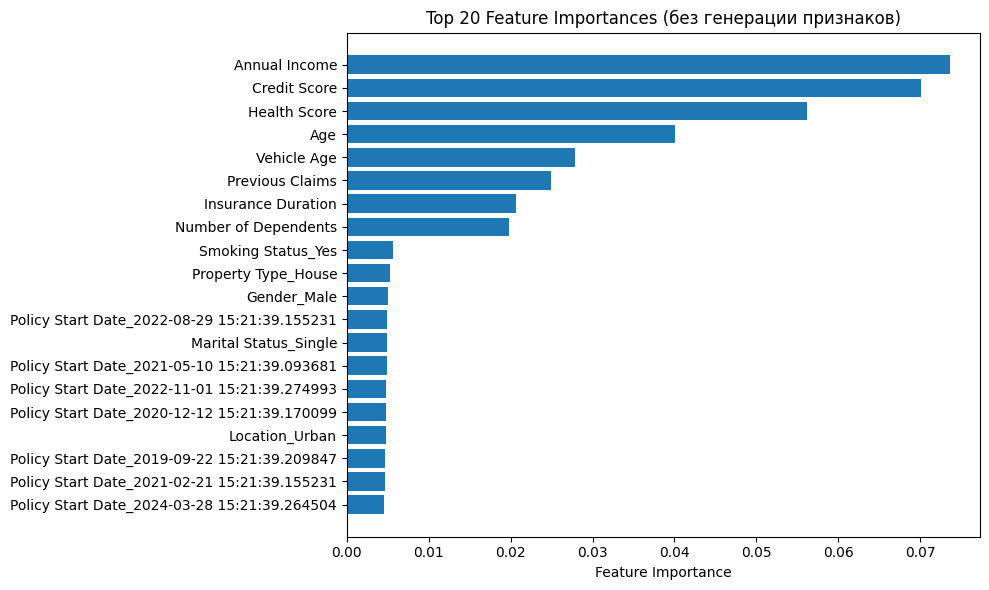

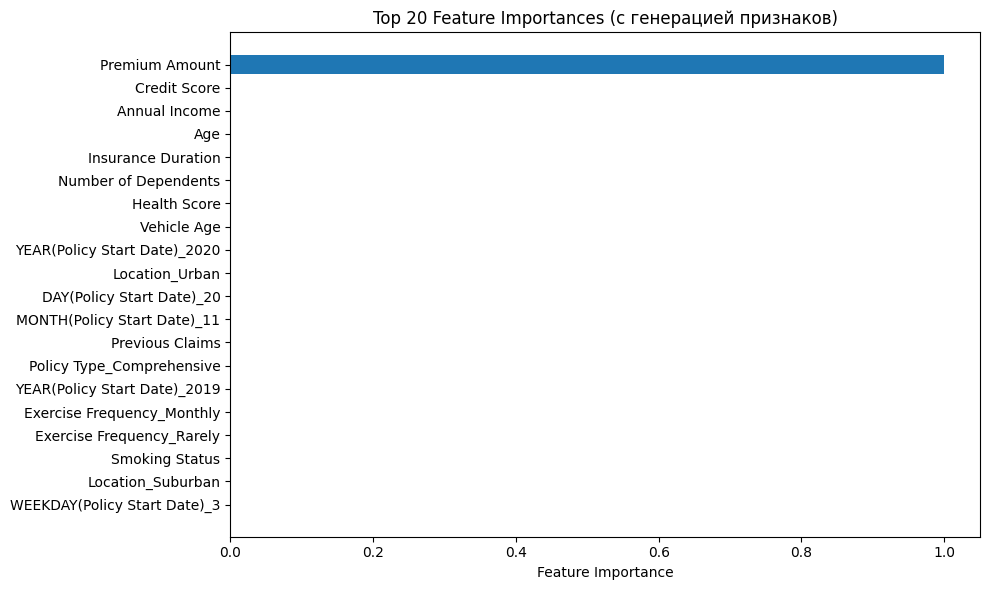

In [79]:
# 10. Отображаем важность признаков
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importance(importances, feature_names, title, top_n=20):
    # Берём только топ-N важных признаков
    sorted_idx = np.argsort(importances)[-top_n:]
    top_features = np.array(feature_names)[sorted_idx]
    top_importances = importances[sorted_idx]

    plt.figure(figsize=(10, 6))
    plt.barh(top_features, top_importances)
    plt.xlabel("Feature Importance")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Важность признаков без генерации
plot_feature_importance(
    rf_model.feature_importances_,
    X.columns,
    "Top 20 Feature Importances (без генерации признаков)"
)

# Важность признаков с генерацией
plot_feature_importance(
    rf_model_gen.feature_importances_,
    X_generated.columns,
    "Top 20 Feature Importances (с генерацией признаков)"
)
